PRUNING FILTERS FOR EFFICIENT CONVNETS (not in date with code)
===

**Reference**: https://arxiv.org/pdf/1608.08710.pdf

**Author**: `Minseong Kim` (tyui592@gmail.com)

### Imports

In [1]:
import os
os.environ['JUPYTER'] = 'True'
# os.environ['JUPYTER_ARGS'] = '--action test --load-path ./pretrained_models/VGG16-CIFAR10-93.7%.pth'
# authors' pruning scheme
os.environ['JUPYTER_ARGS'] = '--action test --load-path ./pretrained_models/VGG16-CIFAR10-pruned-93.4%.pth --prune-layers conv1 conv8 conv9 conv10 conv11 conv12 conv13 --prune-channels 32 256 256 256 256 256 256'

# authors' pruning scheme, with smarter uniqueness
# os.environ['JUPYTER_ARGS'] = '--action test --load-path model.pth --prune-layers conv1 conv8 conv9 conv10 conv11 conv12 conv13 --prune-channels 32 256 256 256 256 256 256 --smarter-uniqueness'

# alternative pruning scheme, with smarter uniqueness
# os.environ['JUPYTER_ARGS'] = '--action test --load-path ./pretrained_models/VGG16-CIFAR10-pruned-92.5%.pth  --prune-layers conv1 conv2 conv8 conv9 conv10 conv11 conv12 conv13 --prune-channels 32 32 256 384 384 384 384 384 --smarter-uniqueness'

import numpy as np
import matplotlib.pyplot as plt

from pthflops import count_ops

import torch

from utils import args
from utils.model import get_model
from utils.data import get_dataloader
from procedures.train import train_network
from procedures.evaluate import test_network, test_step
from procedures.prune import prune_step

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tensor([32, 41, 15,  2, 36, 57, 10, 55, 48, 33, 25,  8, 34, 54, 53, 13, 37,  7,
        44, 52, 42, 31, 38, 21, 62, 35, 51, 14, 11, 29, 59, 23, 46,  3, 20, 60,
         6, 63,  5, 22, 30, 27, 28, 16,  0,  9,  4, 18, 17, 50, 45, 39, 26, 47,
        40, 19, 61, 49, 58,  1, 56, 12, 43, 24])
tensor([445, 502,  48, 168, 281,   1, 339, 500, 325, 253, 474, 161, 102, 209,
        208, 316, 441, 414, 505, 472,  58,  38, 247, 389, 315, 495, 314,  60,
        118, 323,  68, 258, 235, 162,  41, 442, 379, 465, 322,  49,  87, 480,
        176, 329, 461, 404, 448, 318, 156, 299, 407, 282, 440, 418, 114, 362,
        415, 336, 290, 112, 231,   4, 321, 369,  75, 424, 475, 423, 374, 313,
        386, 234,   9, 496, 468,  12, 394, 246, 256, 390, 249, 182,  45, 363,
        233, 295, 178,  20, 111,  23, 383, 159, 279,  91,  90, 210,  74, 489,
        217, 377, 506, 238, 205, 504, 224, 147, 338, 450, 124, 197,  84, 160,
        406, 348,  85,   2, 366, 347, 497, 119,  82, 436, 320, 133, 223, 334,
        4

### Pretrained Model Accuracy

In [2]:
accuracy = test_network()
model = get_model().to(device)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

inp = torch.randn(1, 3, 32, 32).to(device)
count_ops(model, inp)

tensor([ 0, 42, 51, 14, 34, 33, 45, 47, 36, 56, 28, 57, 52, 18, 26,  8,  6,  3,
        49, 54, 15, 16, 12,  1, 53, 29, 13, 62, 20, 63, 21,  5, 23, 22, 19, 27,
        35, 32, 10, 39, 17, 41, 30,  2, 55, 43, 59, 24, 48, 38, 31, 44, 50, 25,
        60, 61, 46,  7, 11, 40,  4, 58,  9, 37])
tensor([487, 204, 199, 296, 436, 177, 411,  69, 469, 363, 459, 201, 488, 292,
        461, 265, 423, 333, 112, 212, 254, 215, 106,  26, 440, 429, 257, 421,
         43, 281, 347, 239, 300, 213,  37,  15,  75, 490, 377,   1, 261,  10,
        154, 416,  27, 345,  53, 295, 378, 268, 145,  46,  73, 415, 144, 366,
         76, 349,  59, 304, 484, 179, 460, 368, 280, 410, 315, 158, 283, 344,
        159, 178, 437, 206, 200, 114, 346,   5, 456, 117, 260, 119, 102, 182,
         20, 413,  16, 309, 237, 223, 428, 231,  39,  34, 262, 146, 110, 148,
        382, 147,  82, 123,   7, 240, 118,   3, 324, 122, 491,  96, 163, 131,
        258, 269, 169, 155, 359, 143, 225, 108, 337,  49,   6, 482, 313, 139,
        3

(207512842,
 [['features_0', 917504],
  ['features_1', 65536],
  ['features_2', 65536],
  ['features_3', 18939904],
  ['features_4', 131072],
  ['features_5', 131072],
  ['features_6', 49152],
  ['features_7', 18907136],
  ['features_8', 65536],
  ['features_9', 65536],
  ['features_10', 37781504],
  ['features_11', 65536],
  ['features_12', 65536],
  ['features_13', 24576],
  ['features_14', 18890752],
  ['features_15', 32768],
  ['features_16', 32768],
  ['features_17', 37765120],
  ['features_18', 32768],
  ['features_19', 32768],
  ['features_20', 37765120],
  ['features_21', 32768],
  ['features_22', 32768],
  ['features_23', 12288],
  ['features_24', 9441280],
  ['features_25', 8192],
  ['features_26', 8192],
  ['features_27', 9441280],
  ['features_28', 8192],
  ['features_29', 8192],
  ['features_30', 9441280],
  ['features_31', 8192],
  ['features_32', 8192],
  ['features_33', 3072],
  ['features_34', 2360320],
  ['features_35', 2048],
  ['features_36', 2048],
  ['features_37'

### Graph the Normalized Absolute Sum of the Filter Weights
This is Figure 2 (a) of the paper.

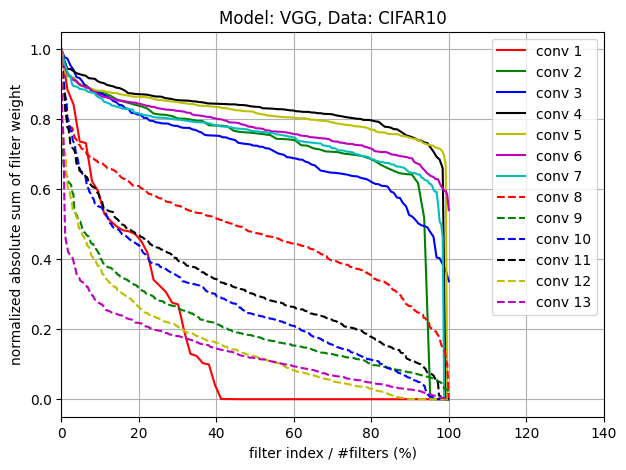

In [3]:
args.load_path = './pretrained_models/VGG16-CIFAR10-93.7%.pth'

colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
lines = ['-', '--', '-.']
plt.figure(figsize=(7, 5))
conv_count = 0
model = get_model()
for layer in model.features:
    if isinstance(layer, torch.nn.Conv2d):
        line_style = colors[conv_count % len(colors)] + lines[conv_count // len(colors)]
        
        # Weights are out_ch x in_ch x k1 x k2
        fw = layer.weight.data.cpu().numpy()
        
        # Sort descending order
        sorted_abs_sum = np.sort(np.sum(np.abs(fw.reshape(fw.shape[0], -1)), axis=1))[::-1]
        
        # Normalize with maximum value
        normalized_abs_sum = sorted_abs_sum / sorted_abs_sum[0]
        conv_count += 1
        plt.plot(np.linspace(0, 100, normalized_abs_sum.shape[0]), normalized_abs_sum, line_style, label="conv %d" % conv_count)
        
plt.title("Model: %s, Data: %s" % (args.model, args.dataset))        
plt.ylabel("normalized absolute sum of filter weight")
plt.xlabel("filter index / #filters (%)")
plt.legend(loc='upper right')
plt.xlim([0, 140])
plt.grid()
# plt.savefig("plots/figure1.png", dpi=150, bbox_inches='tight')
plt.show()        

### Graph the Accuracy of the Network after Pruning
This is Figure 2 (b) of the paper.

Prune each layer 

In [2]:
args.load_path = './pretrained_models/VGG16-CIFAR10-93.7%.pth'
args.smarter_uniqueness = True

prune_step_ratio = 1 / 8
max_channel_ratio = 0.90 

args.load_path = './pretrained_models/VGG16-CIFAR10-93.7%.pth'
prune_channels = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]
prune_layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'conv7', 'conv8', 'conv9', 'conv10', 'conv11', 'conv12', 'conv13']
accuracies = {}

dataloader = get_dataloader(training=False)
model = get_model(prune=False).to(device)
accuracy = test_step(model, dataloader)

for conv, channel in zip(prune_layers, prune_channels): 
    print(f"Pruning {conv}")
    
    accuracies[conv] = [accuracy]
            
    # Remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel * max_channel_ratio), int(1 / prune_step_ratio), dtype=np.int32)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):        
        model = prune_step(model, [conv], [steps[i]], False)
        
        model = model.to(device)
        accuracy = test_step(model, dataloader)
        accuracies[conv].append(accuracy)

Files already downloaded and verified
Pruning conv1
Pruning conv2
Pruning conv3
Pruning conv4
Pruning conv5
Pruning conv6
Pruning conv7
Pruning conv8
Pruning conv9
Pruning conv10


OSError: [Errno 22] Invalid argument

Plot the accuracy graph

In [ ]:
plt.figure(figsize=(7, 5))
for index, (key, value) in enumerate(accuracies.items()):
    line_style = colors[index % len(colors)] + lines[index // len(colors)] + 'o'
    plt.plot(np.linspace(0, 90, len(value)), value, line_style, label=key)

plt.title("Model: %s, Data: %s, pruned smallest filters" % (args.model, args.dataset))        
plt.ylabel("Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
# plt.savefig("plots/figure2_smarter.png", dpi=150, bbox_inches='tight')
plt.show()                

### Graph the Accuracy of the Network after Pruning with Retraining
This is Figure 2 (c) of the paper.

Prune each layer with 1 epoch of retraining

In [3]:
args.epochs = 1
args.lr = 0.0001

accuracies = {}

for conv, channel in zip(prune_layers, prune_channels):    
    print(f"Pruning {conv}")
    
    accuracies[conv] = [accuracy]
    
    model = get_model()
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel * max_channel_ratio), int(1 / prune_step_ratio), dtype=np.int32)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):        
        model = prune_step(model, [conv], [steps[i]], False)
        train_network(model=model, write=False)
        accuracy = test_step(model, dataloader)      
        accuracies[conv].append(accuracy)

Pruning conv1
Files already downloaded and verified
Epoch 1 (42.76497721672058), 	 Accuracy: 99.9320652173913, 	 Loss: 0.0038642520655412225
Files already downloaded and verified
Epoch 1 (37.56763505935669), 	 Accuracy: 99.79219948849105, 	 Loss: 0.008703046697191893
Files already downloaded and verified
Epoch 1 (39.983455419540405), 	 Accuracy: 99.66632033248082, 	 Loss: 0.010764082971727476
Files already downloaded and verified
Epoch 1 (38.08072280883789), 	 Accuracy: 96.75751278772378, 	 Loss: 0.11120838852599263
Files already downloaded and verified
Epoch 1 (36.84073853492737), 	 Accuracy: 95.13746803069054, 	 Loss: 0.16504060700535775
Files already downloaded and verified
Epoch 1 (37.82200479507446), 	 Accuracy: 77.73697250639387, 	 Loss: 0.7177659744024276
Files already downloaded and verified
Epoch 1 (121.58108305931091), 	 Accuracy: 67.4320652173913, 	 Loss: 0.9831119507551194
Pruning conv2
Files already downloaded and verified


KeyboardInterrupt: 

Plot the accuracy graph

In [ ]:
plt.figure(figsize=(7, 5))
for index, (key, value) in enumerate(accuracies.items()):
    line_style = colors[index % len(colors)] + lines[index // len(colors)] + 'o'
    plt.plot(np.linspace(0, 90, len(value)), value, line_style, label=key)

plt.title("Model: %s, Data: %s, pruned smallest filters, retrained %d epochs" % (args.model, args.dataset, args.epochs))        
plt.ylabel("Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("plots/figure2.png", dpi=150, bbox_inches='tight')
plt.show()                